# (Scaled) adaptVQE for the TFIM Chain Hamiltonian

Check the Heisenberg script first.
Main modifications:
- define Hamiltonian (init and in the fulllossfunction to respect data types)
- overlapwithplus instead of overlapwithneel

The plus state has a non-zero overlap with the ground state. Since we are in the critical regime, we have 2 initialisation choises, the plus state (minimizes X term) or the Neel state (minimizes ZZ term).

In [1]:
using PauliPropagation
using Plots
using ReverseDiff
using ReverseDiff: GradientTape, gradient!, compile, gradient
using Bits
using Random
using Distributions: Uniform
using NLopt

### 0) System and Initial State Construction

In [2]:
nq = 3

3

In [3]:
function tfim_1d_obc(nq::Int;topology = nothing, gamma = 1.0)

    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    H = PauliSum(nq)
    for qind in 1:nq
        add!(H, :X, qind, gamma)
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), 1.0)
    end
    return H
end

tfim_1d_obc (generic function with 1 method)

In [4]:
tfim_1d_obc(nq) 

PauliSum(nqubits: 3, 5 Pauli terms:
 1.0 * IXI
 1.0 * IIX
 1.0 * ZZI
 1.0 * IZZ
 1.0 * XII
)

In [5]:
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        # |0101...> → "1" on even sites
        return collect(2:2:nq)
    else
        # |1010...> → "1" on odd sites
        return collect(1:2:nq)
    end
end

neel_bits (generic function with 1 method)

In [6]:
# example usage:
neel_bits(10; up_on_odd=true)

5-element Vector{Int64}:
  2
  4
  6
  8
 10

In [7]:
# customized overlap function
# since we are in the Heisenberg picture, we propagate observables and in the final step, calculate the overlap with the initial state
function overlapwithneel(operator, nq::Int; 
                           up_on_odd::Bool=true, 
                           params=nothing)
                           
    # Create Néel state bit representation: indices of "1" bits
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    
    # Compute overlap with computational basis state
    return overlapwithcomputational(operator, nb)
end

overlapwithneel (generic function with 1 method)

### 1) Full Operator Pool (Hamiltonian-Independent)

In [8]:
function generate_full_bit_pool(nq::Int)
    # Choose appropriate UInt type based on number of qubits (same as PP does)
    # Work with bit representations directly (easier to manipulate)
    UIntType = if nq <= 4
        UInt8
    elseif nq <= 8
        UInt16
    elseif nq <= 16
        UInt32
    else
        UInt64
    end
    
    # Here, we generate all non-identity bit patterns (therefore -1), which gives the full operator pool.
    pool = UIntType[]
    for i in 1:(4^nq - 1)
        push!(pool, UIntType(i))
    end
    
    return pool
end

generate_full_bit_pool (generic function with 1 method)

In [9]:
# Function to convert bit representation to PauliString when needed
function bit_to_paulistring(bit_repr, nq)
    paulis = Symbol[]
    sites = Int[]
    
    for qubit in 1:nq #going from right to left in bitstring
        pauli_val = getpauli(bit_repr, qubit) # get pauli of qubit as 0,1,2,3
        #println("Qubit $qubit: Pauli value = $pauli_val")
        if pauli_val != 0  # Skip identity (0) since Paulis are initialised as identity by default
            pauli_symbol = [:I, :X, :Y, :Z][pauli_val + 1] # julia indexing starts at 1!
            push!(paulis, pauli_symbol)
            push!(sites, qubit)
        end
    end
    
    return PauliString(nq, paulis, sites, 1.0), paulis, sites
end

bit_to_paulistring (generic function with 1 method)

### 2) AdaptVQE Elements and Tests

In [10]:
"""
    calc_gradients(bit_pool, H, nq;
                   circuit=nothing, params=nothing,
                   tol=1e-12, verbose=false, up_on_odd=true)

ADAPT-VQE gradients with in-place propagation:
g_P = ⟨φ₀ | [U† H U, U† P U] i | φ₀⟩, where |φ₀⟩ is the Néel state
selected by `up_on_odd`.
"""
function calc_gradients(bit_pool, H, nq;
                        circuit::Union{Nothing,Any}=nothing,
                        params::Union{Nothing,AbstractVector}=nothing,
                        tol::Float64=1e-12,
                        verbose::Bool=false,
                        up_on_odd::Bool=true)

    grads = Float64[]

    # Pre-propagate H once: H_prop = U† H U (only if a circuit is provided)
    H_prop = H
    if circuit !== nothing
        H_prop = deepcopy(H)                 # avoid mutating H
        propagate!(circuit, H_prop, params)  # in-place propagation
    end

    # For each pool element, pre-propagate P (to P_prop) and form [H_prop, P_prop]
    for (k, bit_repr) in enumerate(bit_pool)
        P= bit_to_paulistring(bit_repr, nq)[1]
        psum = PauliSum(nq)
        P = add!(psum, P) # PP works with PauliSums (see datatypes example notebook)
        #println("Calculating gradient for op[$k]: ", P)

        P_prop = P
        if circuit !== nothing
            P_prop = deepcopy(P)                 # avoid mutating the pool op
            propagate!(circuit, P_prop, params)  # in-place propagation
        end
        
        C = commutator(H_prop, P_prop) 
        if !(iterate(C) !== nothing)           # if the commutator is empty 
            verbose && println("op[$k]: ", P, "  commutator=0  → grad=0.0")
            push!(grads, 0.0)
            continue
        end
        g = overlapwithneel(im * C, nq; up_on_odd=up_on_odd)
        #g = overlapwithplus(im *C)
        if abs(imag(g)) > tol
            @warn "Gradient has non-negligible imaginary part" imag=imag(g) op=P
        end

        push!(grads, real(g))
        verbose && println("op[$k]: ", P, "  grad=", real(g))
    end

    return grads
end

calc_gradients

In [11]:
# example usage
grads = calc_gradients(generate_full_bit_pool(nq), tfim_1d_obc(nq), nq; verbose=false, up_on_odd=true)

63-element Vector{Float64}:
  0.0
 -2.0
  0.0
  0.0
  0.0
  0.0
  0.0
  2.0
  0.0
  0.0
  ⋮
  0.0
  2.0
  0.0
  0.0
  2.0
  0.0
  0.0
  2.0
  0.0

In [12]:
function pick_top_operator(gradients::AbstractVector, operators::AbstractVector; rng=Random.GLOBAL_RNG)
    length(gradients) == length(operators) || throw(ArgumentError("gradients and operators must have same length"))
    isempty(gradients) && throw(ArgumentError("gradients must not be empty"))
    
    mags = abs.(gradients)
    order = sortperm(mags, rev=true)  # indices sorted by |grad| descending (following the nature paper implementation)
    gradients_sorted = gradients[order]
    operators_sorted = operators[order]

    max_mag = mags[order[1]]
    tied_top = filter(i -> mags[i] == max_mag, order)

    chosen_idx = rand(rng, tied_top)

    return operators[chosen_idx], gradients[chosen_idx], gradients_sorted, operators_sorted
end

pick_top_operator (generic function with 1 method)

In [13]:
# example usage:
top_op, top_grad, grads_sorted, ops_sorted = pick_top_operator(grads, generate_full_bit_pool(nq))
println("Top operator: ", bit_to_paulistring(top_op,nq)[1], " with gradient ", top_grad)
println("Top gradient: ", grads_sorted) # we ignore the signs when sorting

Top operator: PauliString(nqubits: 3, 1.0 * ZZY) with gradient 2.0
Top gradient: [-2.0, 2.0, 2.0, 2.0, -2.0, -2.0, 2.0, 2.0, -2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
function check_convergence(gradients; tol=1e-4)
    max_grad = maximum(abs.(gradients))
    return max_grad < tol, max_grad
end

check_convergence (generic function with 1 method)

In [15]:
# example usage:
check_convergence(grads; tol=1e-4)

(false, 2.0)

In [16]:
function pauli_rotation_from_bits(bit_repr, nq)
    _, paulis, sites = bit_to_paulistring(bit_repr, nq) 
    return PauliRotation(paulis, sites)
end

pauli_rotation_from_bits (generic function with 1 method)

In [17]:
# example usage:
pauli_rotation_from_bits(top_op,nq)

PauliRotation([:Z, :Z, :Y], [1, 2, 3])

In [18]:
function append_from_bits!(circuit, thetas, chose_op, nq; theta_init=rand())
    gate = pauli_rotation_from_bits(chose_op, nq)
    push!(circuit, gate) # not pushfirst (Schrödinger!)
    push!(thetas, theta_init) # no factor of 2 to match convention of PP
    return circuit, thetas    # index of the new parameter
end

append_from_bits! (generic function with 1 method)

In [19]:
# example usage:
circuit = Any[]      # initialize the adaptVQE circuit
thetas  = Float64[]  # initialize the parameter list
circuit, thetas = append_from_bits!(circuit,thetas,top_op,nq; theta_init = 0.2)

(Any[PauliRotation([:Z, :Z, :Y], [1, 2, 3])], [0.2])

In [20]:
function fulllossfunction(thetas, circuit, nq; gamma = 1.0, topology = nothing, max_freq = Inf, max_weight = Inf)

    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    # differentiation libraries use custom types to trace through the computation
    # we need to make all of our objects typed like that so that nothing breaks
    CoeffType = eltype(thetas)

    H = PauliSum(CoeffType, nq) #define Hamiltonian again (otherwise Reverse Diff breaks)
    
    for qind in 1:nq
        add!(H, :X, qind, CoeffType(gamma))
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), CoeffType(1.0))
    end


    # wrap the coefficients into PauliFreqTracker so that we can use `max_freq` truncation.
    # usually this happens automatically but the in-place propagate!() function does not allow that.
    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    
    # we also need to run the in-place version with `!`, because by default we copy the Pauli sum
    output_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
    return overlapwithneel(output_H,nq) #overlapwithplus(output_H) # overlapwithneel(output_H,nq)
end

fulllossfunction (generic function with 1 method)

In [21]:
# Gradient Descent
function gd(thetas_init, closed_lossfunction, nq; eta=0.01, steps=200)
    
    #check out automatic diff example notebook for more details
    # some inputs and work buffer to play around with
    grad_array_compiled = similar(thetas_init);

    # pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements
    simulation_tape = GradientTape(closed_lossfunction, thetas_init)
    compiled_simulation_tape = compile(simulation_tape)
    
    opt_energy_gd = []
    thetas = thetas_init
    for i in 1:steps 
        gradient!(grad_array_compiled, simulation_tape, thetas)
        thetas .-= eta * grad_array_compiled
        opt_energy_gd = push!(opt_energy_gd, closed_lossfunction(thetas)/nq)
    end
    return thetas, opt_energy_gd
end

gd (generic function with 1 method)

In [22]:
function adam_optimizer(thetas_init, lossfun, nq; eta=0.02, steps=150, refresh_grad_tape=50)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Float64[]

    m = zero(thetas)
    v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps

        if t%refresh_grad_tape == 0 # refresh the tape to avoid wrong gradients
                tape = GradientTape(lossfun, thetas)
                compile(tape)
        end
        gradient!(grad, tape, thetas)
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        m̂ = m ./ (1 - β1^t)
        v̂ = v ./ (1 - β2^t)
        thetas .-= eta .* m̂ ./ (sqrt.(v̂) .+ ϵ)
        push!(opt_energy, lossfun(thetas) / nq)
    end
    return thetas, opt_energy
end


adam_optimizer (generic function with 1 method)

In [23]:
function lbfgs_optimizer(thetas_init, lossfun, nq; max_iters=300, refresh_grad_tape=50)
    n = length(thetas_init)
    tape_ref = Ref(GradientTape(lossfun, thetas_init)) # Ref is only necessary in the LBFGS case because the closure otherwise can’t update an outer variable that NLopt is still using.
    compile(tape_ref[])
    gradbuf = zeros(n)
    iter_ref = Ref(0)
    opt = NLopt.Opt(:LD_LBFGS, n)
    NLopt.maxeval!(opt, max_iters)

    opt_energy = Float64[]
    NLopt.min_objective!(opt, (x, grad) -> begin

        iter_ref[] += 1
        # Re-record the tape every `refresh_grad_tape` evaluations
        # record with the current x so shapes/aliasing match
        if refresh_grad_tape > 0 && (iter_ref[] % refresh_grad_tape == 0)
            tape_ref[] = GradientTape(lossfun, x)
            compile(tape_ref[])
        end

        fx = lossfun(x)::Float64
        if !isempty(grad)
            gradient!(gradbuf, tape_ref[], x)
            grad .= gradbuf
        end
        push!(opt_energy, fx)
        return fx
    end)
    minf, thetas, ret = NLopt.optimize(opt, thetas_init)
    return thetas, opt_energy ./ nq
end


lbfgs_optimizer (generic function with 1 method)

In [24]:
function target_optimization(nq, circuit, thetas; gamma = 1.0, max_freq=Inf, max_weight=Inf, refresh_grad_tape=10, verbose = false)
    # again, automatic diff example notebook for more details
    closed_lossfunction = let const_nq=nq, const_gamma = gamma, const_max_freq=max_freq, const_max_weight=max_weight
        # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
        # See also "closures"
        theta -> fulllossfunction(theta, circuit, const_nq; gamma = const_gamma, max_freq=const_max_freq, max_weight=const_max_weight)
    end
    
    opt_thetas, opt_energy_gd = lbfgs_optimizer(thetas,closed_lossfunction,nq;refresh_grad_tape=refresh_grad_tape)
    if verbose
        println("Optimized thetas: ", opt_thetas)
        println("Optimized energy per qubit: ", opt_energy_gd[end])

        plot(opt_energy_gd)
        display(plot!(title = "Energy optimisation", xlabel = "runs", ylabel = "E/Q"))
    end

    return opt_thetas, opt_energy_gd
end

target_optimization (generic function with 1 method)

### 3) AdaptVQE Loop

In [25]:
function adaptVQE_loop(nq, hamiltonian, bit_pool; max_iters=10, conv_tol=1e-4, refresh_grad_tape=10, verbose=true)
    circuit = Any[]      # initialize the adaptVQE circuit
    thetas  = Float64[]; # initialize the parameter list
    energy_per_loop = Float64[];
    max_grads = Float64[] # collect for analysis
    chosen_ops = UInt[]

    for iter in 1:max_iters

        # 1) Calculate gradients
        grads = calc_gradients(bit_pool, hamiltonian, nq; circuit=circuit, params=thetas, tol=1e-12, verbose=false, up_on_odd=true)

        # 2) Check convergence
        converged, max_grad = check_convergence(grads; tol=conv_tol)
        push!(max_grads, max_grad)
        
        if converged
            #println("Convergence achieved with max gradient < $conv_tol")
            break
        end

        # 3) Pick top operator
        chose_op, grad_op, grads_sorted, _ = pick_top_operator(grads, bit_pool)

        push!(chosen_ops, chose_op)

        # 4) Append operator to circuit
        theta_init = rand(Uniform(-π, π)) #rand() goes from 0 to 1
        circuit, thetas = append_from_bits!(circuit, thetas, chose_op, nq; theta_init=theta_init) # theta_init is multiplied by 2 in append function

        # 5) Optimize parameters
        thetas, opt_energy_gd = target_optimization(nq, circuit, thetas; refresh_grad_tape=refresh_grad_tape, verbose=verbose)
        # wrap the thetas to [-π,π] since they are angles
        thetas = rem2pi.(thetas,RoundNearest) # does not seem to help the optimization
        push!(energy_per_loop, opt_energy_gd[end])
    end

    # 6) Plot the gradient convergence
    if verbose
        plot(max_grads, marker=:o)
        display(plot!(title = "Max Gradient Convergence", xlabel = "Iteration", ylabel = "Max Gradient"))
    end

    return circuit, thetas, chosen_ops, energy_per_loop, max_grads
end

adaptVQE_loop (generic function with 1 method)

In [26]:
nq = 3
hamiltonian = tfim_1d_obc(nq; topology=bricklayertopology(nq;periodic=false))
full_bit_pool = generate_full_bit_pool(nq)
circuit, thetas, chosen_ops, energy_per_loop, max_grads = adaptVQE_loop(nq, hamiltonian, full_bit_pool; max_iters=20, conv_tol=1e-4, verbose=false);

In [27]:
println("max grads: ", max_grads)

max grads: [2.0, 2.0, 1.9999999999999996, 0.9682458395692054, 0.3885239903851724, 2.327524428746841e-8]


In [28]:
println("size of full bit pool: ", size(full_bit_pool))

size of full bit pool: (63,)


In [29]:
println("Final thetas: ", thetas)

Final thetas: [-1.111993019942717, 4.2571456798883034e-10, -1.0662221774864307, 1.5707963261363682, -0.09870928808957834]


In [30]:
energy_per_loop # -1.1646530  is the ED result for 3 qubits, -1.18969 is ED for 4 qubits, -1.2053348 is ED for 5 qubits.

5-element Vector{Float64}:
 -0.8047378541243649
 -0.896437450125371
 -1.0540925533894596
 -1.1614784439219523
 -1.1646530691449781

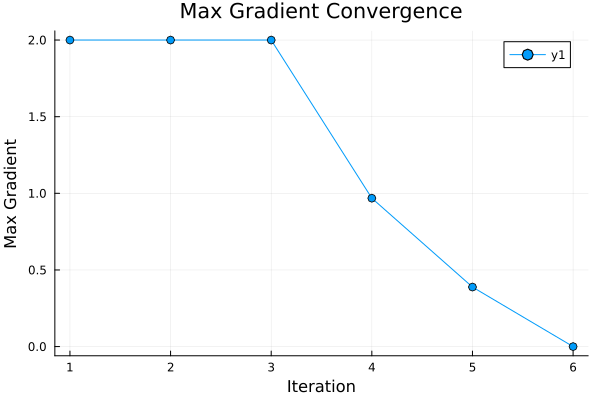

In [31]:
plot(max_grads, marker=:o)
plot!(title = "Max Gradient Convergence", xlabel = "Iteration", ylabel = "Max Gradient")

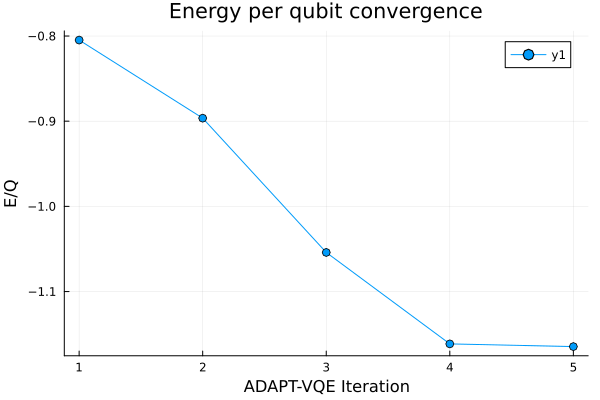

In [32]:
plot(energy_per_loop, marker=:o)
plot!(title = "Energy per qubit convergence", xlabel = "ADAPT-VQE Iteration", ylabel = "E/Q")

### 4) Multiple Small ADAPT runs for Pool Generation

In [33]:
function scaled_pool_selection(nq, hamiltonian, full_bit_pool; num_runs=5, run_iters=5, conv_tol=1e-4, refresh_grad_tape=10, verbose=false)
    all_chosen_ops = UInt[]
    for run in 1:num_runs
        #println("=== ADAPT-VQE Run $run ===")
        circuit, thetas, chosen_ops = adaptVQE_loop(nq, hamiltonian, full_bit_pool; max_iters=run_iters, conv_tol=conv_tol, refresh_grad_tape=refresh_grad_tape, verbose=verbose)
        append!(all_chosen_ops, chosen_ops)
    end
    return unique(all_chosen_ops)  # Return unique operators from all runs
end


function scaled_pool_generation(tile_nq, scaled_nq,hamiltonian, full_bit_pool; num_runs=5, run_iters=5, conv_tol=1e-4, refresh_grad_tape=10, verbose=false)
    #Choose appropriate UInt type based on number of qubits (same as PP does)
        UIntType = if scaled_nq <= 4
            UInt8
        elseif scaled_nq <= 8
            UInt16
        elseif scaled_nq <= 16
            UInt32
        else
            UInt64
        end

        chosen_ops = scaled_pool_selection(tile_nq, hamiltonian, full_bit_pool; num_runs=num_runs, run_iters=run_iters, conv_tol=conv_tol, refresh_grad_tape=refresh_grad_tape, verbose=verbose)
        println("Chosen operators from tile ADAPT-VQE: ", length(chosen_ops))
        scaled_pool = UIntType[]
        for op in chosen_ops
            ps, paulis, sites = bit_to_paulistring(op, tile_nq) 
            weight = length(paulis)
            # Preserve the operator's internal geometry: compute zero-based relative offsets
            min_site = minimum(sites)
            rel_sites = sites .- min_site
            block_span = maximum(rel_sites) + 1 # equivalent to block_span = maximum(sites) - minimum(sites) + 1
        # Slide the block from left to right without wrapping (open boundaries)
        for start in 1:(scaled_nq - block_span + 1)
            new_sites = start .+ rel_sites  # keep internal offsets
            new_op = PauliString(scaled_nq, paulis, collect(new_sites), 1.0)
            push!(scaled_pool, (new_op.term))
        end
    end
    return unique(scaled_pool)
end

scaled_pool_generation (generic function with 1 method)

### Run AdaptVQE with new Pool

In [34]:
# check the scaled pool generation
tile_nq = 3
scaled_nq = 8 

tile_full_bit_pool = generate_full_bit_pool(tile_nq)
tile_hamiltonian = tfim_1d_obc(tile_nq; topology=bricklayertopology(tile_nq;periodic=false))

scaled_pool = scaled_pool_generation(tile_nq, scaled_nq, tile_hamiltonian, tile_full_bit_pool; num_runs=10, run_iters=10, conv_tol=1e-2, verbose=false) 
# need approx. 10 runs to hit the 12 different operators 
scaled_hamiltonian = tfim_1d_obc(scaled_nq; topology=bricklayertopology(scaled_nq;periodic=false))
println("Scaled adaptVQE loop:")
circuit, thetas, chosen_ops, opt_energy_gd, max_grads = adaptVQE_loop(scaled_nq, scaled_hamiltonian, scaled_pool; max_iters=30, conv_tol=1e-2, refresh_grad_tape=10, verbose=false);
println("opt_energy_gd: ", opt_energy_gd)
println("max grads: " , max_grads)

println("GS energy per qubit: ", opt_energy_gd[end], " with adaptVQE gradient ", max_grads[end])

Chosen operators from tile ADAPT-VQE: 15
Scaled adaptVQE loop:
opt_energy_gd: [-0.9045084971874737, -0.9340169943749475, -0.9906725409844879, -1.0201810381719616, -1.076836584781502, -1.1085246283214176, -1.1415804002312349, -1.1753097231521965, -1.1804070789917103, -1.1855044919487854, -1.1913821297567269, -1.197269676778071, -1.2007265523150397, -1.20339935415927, -1.2061242794658202, -1.2073870066504497, -1.2082914523700679, -1.2087242737545933, -1.2094022998264478, -1.2099959048949955, -1.210410759530508, -1.211016435053826, -1.2116666041404627, -1.2131602181827037, -1.2147702766512765, -1.2161647336582055, -1.2179293046892015, -1.2182998044303808, -1.2209622029099563, -1.2223388402592956]
max grads: [2.0, 2.0000000000000004, 2.0000000000000004, 2.0, 2.0, 2.0, 2.0, 1.9999999999999996, 0.7470697072409658, 0.7470815890257676, 0.6688470026052481, 0.6689947453748918, 0.5555789352785592, 0.5245260721975467, 0.5079311402808073, 0.4255438602671784, 0.29641747189880985, 0.2800539394793272,

In [35]:
println("final energy per qubit: ", opt_energy_gd[end])

final energy per qubit: -1.2223388402592956


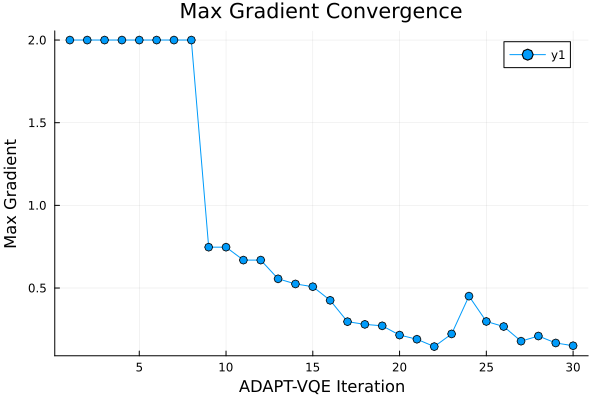

In [36]:
plot(max_grads, marker=:o)
plot!(title = "Max Gradient Convergence", xlabel = "ADAPT-VQE Iteration", ylabel = "Max Gradient")

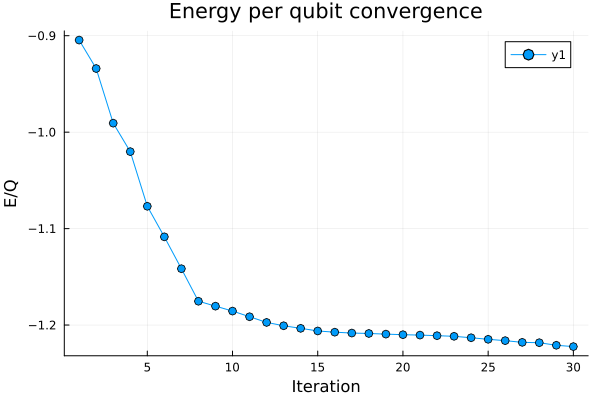

In [37]:
plot(opt_energy_gd, marker=:o)
display(plot!(title = "Energy per qubit convergence", xlabel = "Iteration", ylabel = "E/Q"))